# Make a facial keypoint detector
In order to train this, we need a training set - a set of facial image / facial keypoint pairs to train on. For this we will be using [this dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) from Kaggle. 

Make sure that you have both the training and test data files. The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates. This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, run the Python cell below - notice we will load in both the training and testing sets.

## Helper Functions
First, let's define some helper methods we will find useful.

In [1]:
import cv2
import pandas as pd
import os
import numpy as np
from PIL import Image
import time
from sklearn.utils import shuffle

In [2]:

def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """  
    FTRAIN = 'data/training.csv'
    FTEST = 'data/test.csv'
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname), error_bad_lines = False)  # load dataframes

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2], 
        landmarks[1::2], 
        marker='o', 
        c='c', 
        s=40)

def plot_keypoints(img_path, 
                  face_cascade=cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_alt.xml'),
                  model_path='my_model.h5'):
    #A function that plots keypoints on arbitrary image containing human
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

    if len(faces) == 0:
        plt.title('no faces detected')
    elif len(faces) > 1:
        plt.title('too many faces detected')
        for (x,y,w,h) in faces:
            rectangle = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)
            ax.imshow(cv2.cvtColor(rectangle, cv2.COLOR_BGR2RGB))
    elif len(faces) == 1:
        plt.title('one face detected')
        x,y,w,h = faces[0]
        bgr_crop = img[y:y+h, x:x+w] 
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        model = load_model(model_path)
        landmarks = np.squeeze(model.predict(
            np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        ax.scatter(((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x, 
                   ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y, 
                   marker='o', c='c', s=40)
    plt.show()

In [3]:
# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


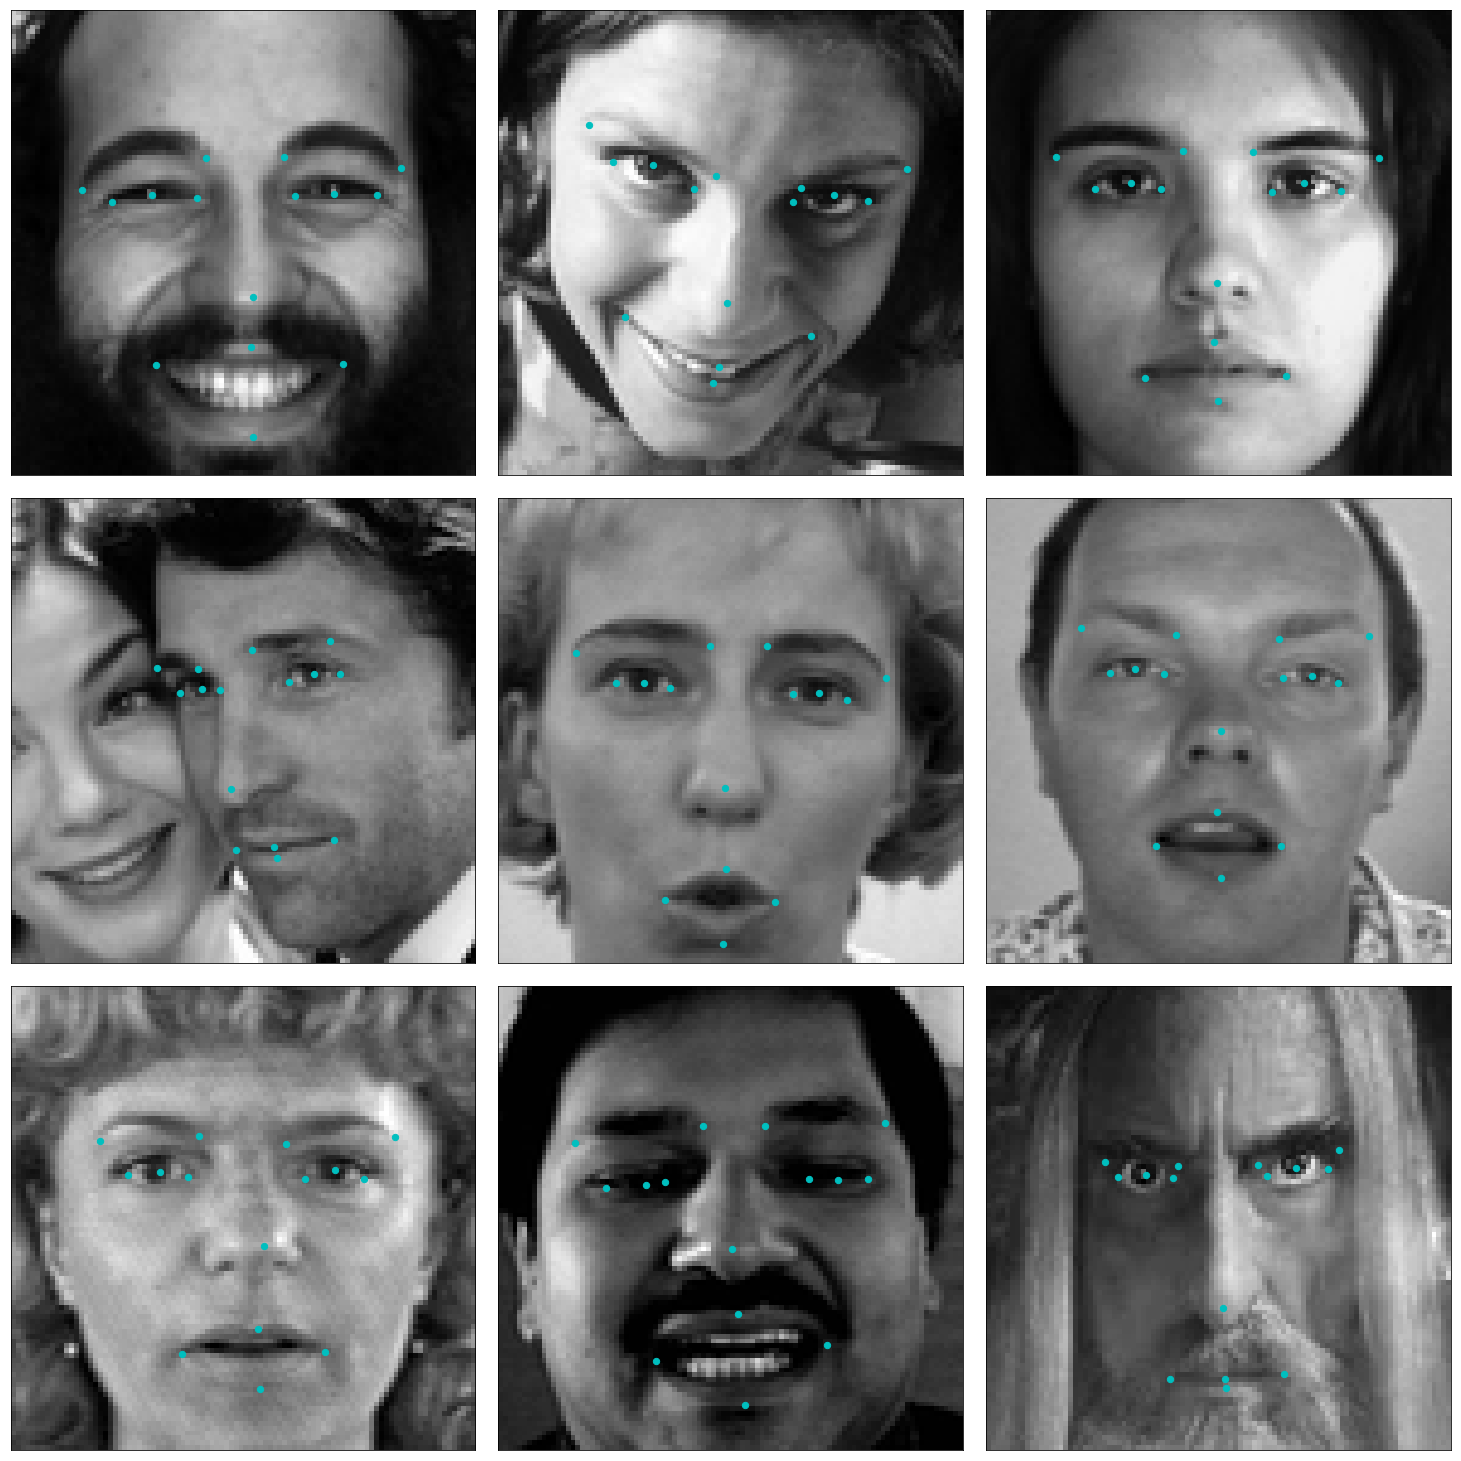

In [4]:
import matplotlib.pyplot as plt #Getting pyplot module
%matplotlib inline

# Creating a figure (a graph)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # Adjusting plots, don't worry about this
for i in range(9): # For i images, 
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[]) # Show them in rows of 3 and columns of 3
    plot_data(X_train[i], y_train[i], ax) #Show 9 images from the data

# Convolutional Neural network implementation

### How should our CNN work?

We want it to take in a 96 x 96 grayscale image (96, 96, 1) and be able to automatically detect the location of the facial keypoints.

So, we will have 4 layers - an input layer, two middle layers, and one final prediction layer

The model is defined below:

In [5]:
# Import deep learning resources from Keras
from keras.models import Sequential # A model type
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.layers import Conv2D, GlobalAveragePooling2D

# The model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)

model = Sequential()

#first layer - 16 filter layer with a 3x3 kernel, little padding around to constitute for the loss of image because of the 
#kernel, a relu activation function, and a 96x96 input shape for the grayscale image
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2)) # Adding a max pooling (halving the size of the image to 48 x 48)

#second layer - 32 filter layer, 2x2 kernel, little padding around to constitute for the loss of image because of the 
#kernel, a relu activation function
model.add(Conv2D(filters=32, kernel_size=(2,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2)) # Add a max pooling(halving the size of the image to 24 x 24)
model.add(Dropout(0.4)) # Randomly removing about half of the neurons(helps overfitting)

#third layer - 64 filter layer, 2x2 kernel, little padding around to constitute for the loss of image because of the 
#kernel, a relu activation function
model.add(Conv2D(filters=64, kernel_size=(2,2), padding='same', activation='relu')) # Third layer
model.add(MaxPooling2D(pool_size=2)) # Adding a max pooling (halving size of image to 12 x 12)
model.add(Dropout(0.5)) # Randomly removing about half of the neurons(helps overfitting)

model.add(Flatten()) # Flattening the entire model to make a final prediction (144 )
model.add(Dense(256, activation='softmax')) # Adding a softmax activation function
model.add(Dropout(0.5)) # Removing 50% of the neurons randomly
model.add(Dense(30)) # Final layer. 

# Summarize the model
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
__________

### Compilation of model + training

The compile method is used to configure the learning process. Experiment with your choice of optimizer; you may have some ideas about which will work best (SGD vs. RMSprop, etc), but take the time to empirically verify your theories.

The fit method is used to train the model. Break off a validation set by setting validation_split=0.2. Save the returned History object in the history variable.

Experiment with your model to minimize the validation loss (measured as mean squared error). A very good model will achieve about 0.0015 loss (though it's possible to do even better). 

When you have finished training, save your model as an HDF5 file with file path my_model.h5.

In [6]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

#Compile the model
#model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer="RMSprop", loss="mean_squared_error", metrics=["accuracy"] )

#Train the model
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='my_model.h5', 
                               verbose=1, save_best_only=True)

## Done: Train the model
hist = model.fit(X_train,y_train,batch_size=32,epochs=20,
                 verbose=1,validation_split=0.2,callbacks=[checkpointer])

model.save('my_model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/20
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0980 - acc: 0.1121 - val_loss: 0.0731 - val_acc: 0.0327

Epoch 00001: val_loss improved from inf to 0.07305, saving model to my_model.h5
Epoch 2/20
1712/1712 [==============================] - 9s 5ms/step - loss: 0.0561 - acc: 0.1215 - val_loss: 0.0437 - val_acc: 0.2523

Epoch 00002: val_loss improved from 0.07305 to 0.04368, saving model to my_model.h5
Epoch 3/20
1712/1712 [==============================] - 9s 5ms/step - loss: 0.0320 - acc: 0.1536 - val_loss: 0.0233 - val_acc: 0.2500

Epoch 00003: val_loss improved from 0.04368 to 0.02328, saving model to my_model.h5
Epoch 4/20
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0188 - acc: 0.1828 - val_loss: 0.0131 - val_acc: 0.2523

Epoch 00004: val_loss improved from 0.02328 to 0.01309, saving model to my_model.h5
Epoch 5/20
1712/1712 [==============================] - 14s 8ms/step - loss: 0.

### Visualizing loss

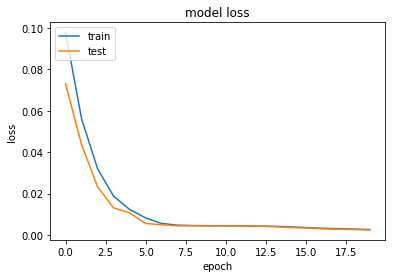

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

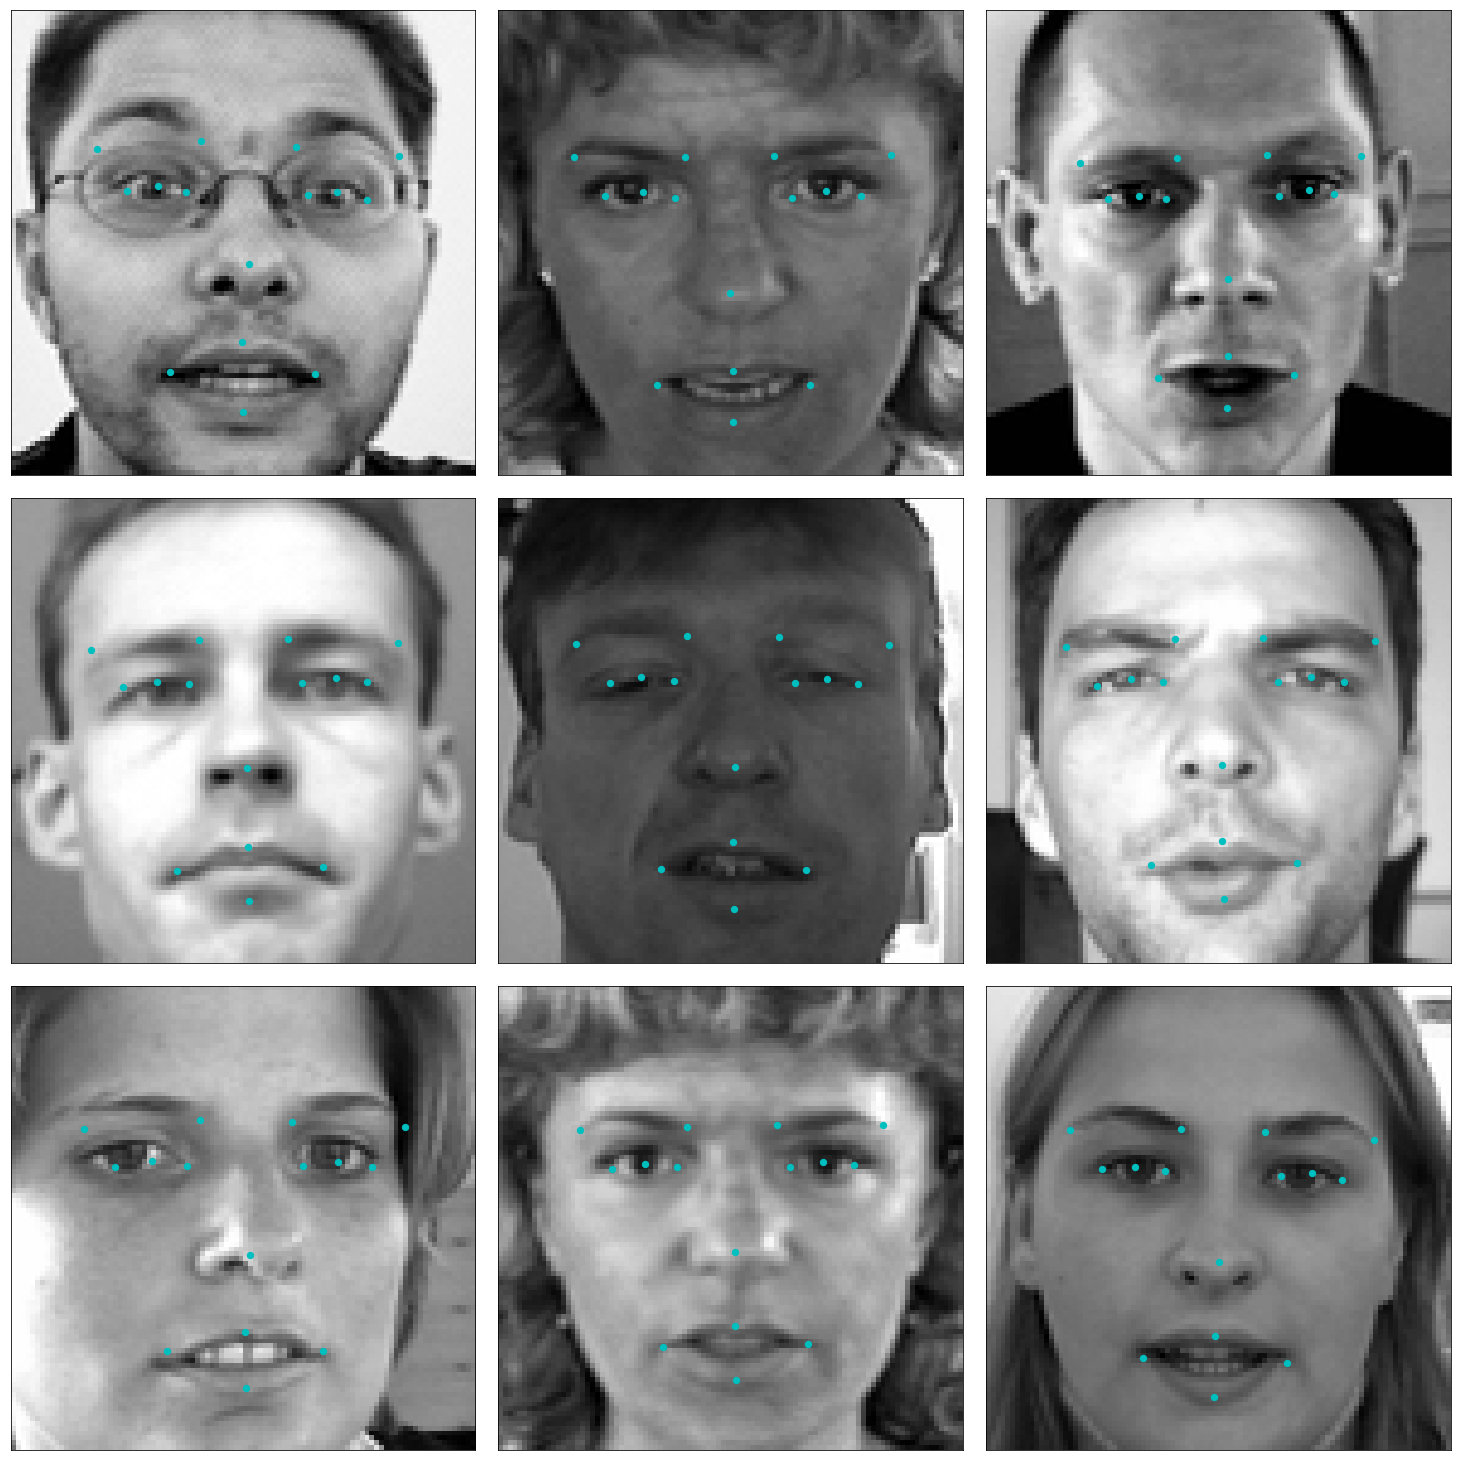

In [8]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

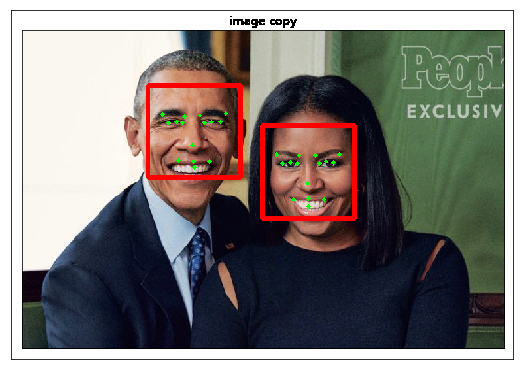

In [9]:
# Getting the image and converting to RGB
image = cv2.imread("images/obamas4.png") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
# Detect the faces in image
faces = face_cascade.detectMultiScale(image_gray, 2, 6)

image_with_detections = np.copy(image)

detectedpoints =[]
for (x,y,w,h) in faces:
  # draw the rectangle thing
  cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
  # get the face
  face = image_with_detections[y:y+h, x:x+w, :]
  
  # scale the face to 96*96
  face_scaled = cv2.resize(face, (96, 96))
  face_gray = cv2.cvtColor(face_scaled, cv2.COLOR_RGB2GRAY)
  face_normalized = face_gray / 255.
  face_normalized = face_normalized[np.newaxis, :, :, np.newaxis]
  
  # predict the model
  key_points = model.predict(face_normalized)
  
  
  key_points = key_points * 48 + 48
  #print (key_points)  
  new_x = key_points[0][0::2]
  new_y = key_points[0][1::2]
  
  #print (ypoint)
  new_x = new_x * w / 96 + x
  new_y = new_y * h / 96 + y
  #print (key_points)  
        
  detectedpoints.append((new_x,new_y)) 

## TODO : Paint the predicted keypoints on the test image
for point in detectedpoints:
    for x, y in zip(point[0], point[1]):
        cv2.circle(image_with_detections, (x, y), 2, (0,255,0), -1)

        
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
plt.imshow(image_with_detections, cmap='gray') # plot the image